In [2]:
from tensorflow.keras import layers, Model, Input, models
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
(train_image, train_y),(test_image,test_y) = fashion_mnist.load_data()
train_image, val_image, train_y, val_y = train_test_split(train_image, train_y, test_size=0.1)
train_imageSet1 = train_image[:,:14,:]
train_imageSet2 = train_image[:,14:,:]
test_imageSet1 = test_image[:,:14,:]
test_imageSet2 = test_image[:,14:,:]
# 0.1 test_size means 10%
print(train_image.shape, train_y.shape)
# to use categorical_crossentropy, we need one hot encoding which can be done by:
one_hot_y = utils.to_categorical(train_y)

(54000, 28, 28) (54000,)


In [41]:
inputImage1 = Input((14,28), name = 'input1')
inputImage2 = Input((14,28), name = 'input2')
totalInput = layers.Concatenate(axis=-1)([inputImage1,inputImage2])
# Concatenate layer concatenates the two input tensor/layers 
# along the dimension specified by axis (default -1) 
curLayer = layers.Flatten()
curLayer = curLayer(totalInput)
curLayer = layers.Dense(64, activation='relu',name='Dense1')(curLayer)
# a layer object, except for Input and Lambda layers, is a method. 
# the method's input is whatever tensor you want to chug into the layer. 
# (whatever the previous layer outputs)
# it outputs a layer object (connected to whatever its input is).
curLayer = layers.Dense(64, activation='relu',name='Dense2')(curLayer)
print(type(curLayer))
# we see a tensorflow because the transformation a layer records is stored as a weight tensor.
curLayer = layers.Dense(10, activation='linear', name='Dense3',trainable=False)(curLayer)
# trainable=False simply freezes the weights of the layer (useful in transfer learning).
# we can also set this attribute later. It must be set before we compile!
output = layers.Softmax(name='output1')(curLayer)
curLayer = layers.ReLU()(curLayer)
output2 = layers.Dense(1, activation='sigmoid',name='output2')(curLayer)

<class 'tensorflow.python.framework.ops.Tensor'>


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 14, 28)]     0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 14, 28)]     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 14, 56)       0           input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           concatenate_1[0][0]   

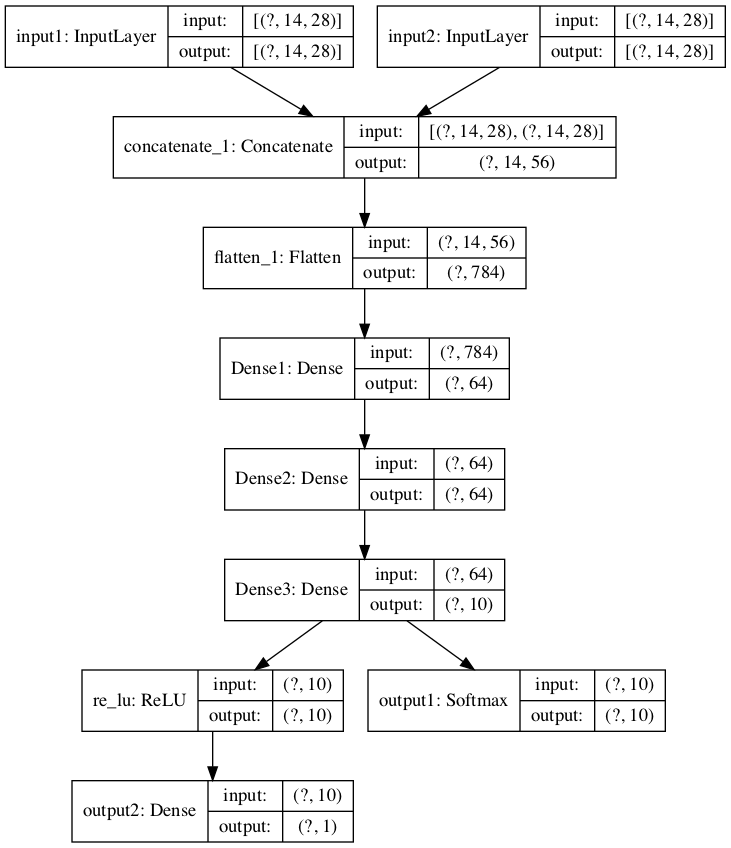

In [7]:
model = Model(inputs=[inputImage1,inputImage2], outputs = [output,output2])
# to build the model (string the layers together), we just specify 
# the input layer and the output layer (they are really a wrapped tensor). 
# The others are not needed because each layer records its connectivity to its parent layer(s).
# All inputs and outputs should be specified so we can specify loss functions/metrics for each output.
# We also need to correspond our input data for each input tensor/layer
model.summary()
utils.plot_model(model,'mymodel.png',show_shapes=True)
# this prints a map of the model; show_shapes indicates whether input/output dimensions are shown.

In [8]:
model.compile(
    optimizer='adam',
    loss=['sparse_categorical_crossentropy','binary_crossentropy'],
    loss_weights=[1.0,0.1],
    metrics=[['sparse_categorical_accuracy'],
    ['binary_accuracy']]
)
# we specify a list of losses, each corresponding to an output layer 
# (in the sequence specified in outputs= when we created the Model)
# loss_weights is in the same sequence. We need it because we need a final loss to do gradient descent on.
# loss_weights determines which linear combination we use for the final weight.
# for metrics, similarly we create two lists of lists of metrics.

In [21]:
model2 = models.clone_model(model)

In [22]:
model2.compile(
    optimizer='adam',
    loss={'output1':'sparse_categorical_crossentropy','output2':'binary_crossentropy'},
    loss_weights={'output1':1.0,'output2':0.1},
    metrics={'output1':['sparse_categorical_accuracy'],'output2':['binary_accuracy']}
)

In [80]:
history = model.fit(
    x=[train_imageSet1,train_imageSet2],
    y=[train_y,np.remainder(train_y,2)],
    batch_size=64,
    epochs=20,
    validation_split=0.15
)

Epoch 1/20
718/718 [==============================] - 1s 2ms/step - loss: 3.4933 - output1_loss: 3.3214 - output2_loss: 1.7195 - output1_sparse_categorical_accuracy: 0.6898 - output2_binary_accuracy: 0.5706 - val_loss: 1.0167 - val_output1_loss: 0.9459 - val_output2_loss: 0.7076 - val_output1_sparse_categorical_accuracy: 0.7214 - val_output2_binary_accuracy: 0.5963
Epoch 2/20
718/718 [==============================] - 1s 1ms/step - loss: 0.8252 - output1_loss: 0.7572 - output2_loss: 0.6802 - output1_sparse_categorical_accuracy: 0.7691 - output2_binary_accuracy: 0.5886 - val_loss: 0.7294 - val_output1_loss: 0.6643 - val_output2_loss: 0.6511 - val_output1_sparse_categorical_accuracy: 0.7974 - val_output2_binary_accuracy: 0.6200
Epoch 3/20
718/718 [==============================] - 1s 1ms/step - loss: 0.6943 - output1_loss: 0.6349 - output2_loss: 0.5942 - output1_sparse_categorical_accuracy: 0.7964 - output2_binary_accuracy: 0.6688 - val_loss: 0.7347 - val_output1_loss: 0.6808 - val_outpu

In [23]:
input_dict = {'input1':train_imageSet1,'input2':train_imageSet2}
label_dict = {'output1':train_y,'output2':np.remainder(train_y,2)}
model2.fit(x=input_dict, y=label_dict, batch_size=64, epochs = 20, validation_split=0.15)

Epoch 1/20
718/718 [==============================] - 1s 2ms/step - loss: 2.6424 - output1_loss: 2.4868 - output2_loss: 1.5559 - output1_sparse_categorical_accuracy: 0.6740 - output2_binary_accuracy: 0.8476 - val_loss: 0.8026 - val_output1_loss: 0.7805 - val_output2_loss: 0.2205 - val_output1_sparse_categorical_accuracy: 0.7356 - val_output2_binary_accuracy: 0.9396
Epoch 2/20
718/718 [==============================] - 1s 1ms/step - loss: 0.7054 - output1_loss: 0.6882 - output2_loss: 0.1722 - output1_sparse_categorical_accuracy: 0.7526 - output2_binary_accuracy: 0.9492 - val_loss: 0.7018 - val_output1_loss: 0.6859 - val_output2_loss: 0.1588 - val_output1_sparse_categorical_accuracy: 0.7652 - val_output2_binary_accuracy: 0.9479
Epoch 3/20
718/718 [==============================] - 1s 1ms/step - loss: 0.6365 - output1_loss: 0.6222 - output2_loss: 0.1438 - output1_sparse_categorical_accuracy: 0.7773 - output2_binary_accuracy: 0.9551 - val_loss: 0.6458 - val_output1_loss: 0.6325 - val_outpu

In [ ]:
print(history.history.keys())

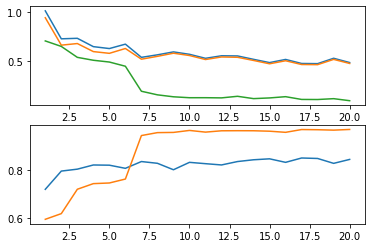

In [82]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(range(1,21),history.history['val_loss'])
ax1.plot(range(1,21),history.history['val_output1_loss'])
ax1.plot(range(1,21),history.history['val_output2_loss'])
ax2.plot(range(1,21),history.history['val_output1_sparse_categorical_accuracy'])
ax2.plot(range(1,21),history.history['val_output2_binary_accuracy'])

In [91]:
model.evaluate(x=[test_imageSet1,test_imageSet2],y=[test_y,np.remainder(test_y,2)])
# obviously we could also use the dictionary approach

313/313 [==============================] - 0s 840us/step - loss: 0.5065 - output1_loss: 0.4963 - output2_loss: 0.1016 - output1_sparse_categorical_accuracy: 0.8302 - output2_binary_accuracy: 0.9677


[0.5064949989318848,
 0.4963343143463135,
 0.10160857439041138,
 0.8302000164985657,
 0.9677000045776367]

In [13]:
print(model.get_layer('Dense2').weights)
print(model.layers[4].kernel)
print(model.get_layer('Dense1').bias)
# The weights of a layer are all variables, meaning that they have definite values. 
# So a model comes in two parts: its weights and its architecture. 
# The architecture is stored as tensors 
# (each tensor, as a review, is an expression of how to compute its value). 
# The weights are stored as Variables 
# (and they are needed of course to compute the actual value of the tensor). 
# the tensor's expression is explicitly dependent on the weight variables.
# So when we do transfer learning, the original weights are preserved 
# even though we are just manipulating output and input tensors

[<tf.Variable 'Dense2/kernel:0' shape=(64, 64) dtype=float32, numpy=
array([[ 0.12998761, -0.15345228,  0.02745719, ..., -0.19347245,
         0.17390968,  0.0043675 ],
       [ 0.16110472,  0.0835738 , -0.18742505, ..., -0.01336761,
        -0.13596681,  0.03306124],
       [-0.19596925, -0.06624356, -0.18045792, ..., -0.20281617,
        -0.10261853, -0.02493581],
       ...,
       [ 0.00876307,  0.06029414, -0.17265058, ...,  0.19159345,
         0.04649211, -0.08096027],
       [ 0.08307068,  0.12046559,  0.07829352, ..., -0.169529  ,
        -0.1665893 , -0.12882072],
       [ 0.16244538, -0.1721302 ,  0.0592777 , ...,  0.04914595,
        -0.20404518,  0.05378599]], dtype=float32)>, <tf.Variable 'Dense2/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.

Model: "functional_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 14, 28)]     0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 14, 28)]     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 14, 56)       0           input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           concatenate_1[0][0]   

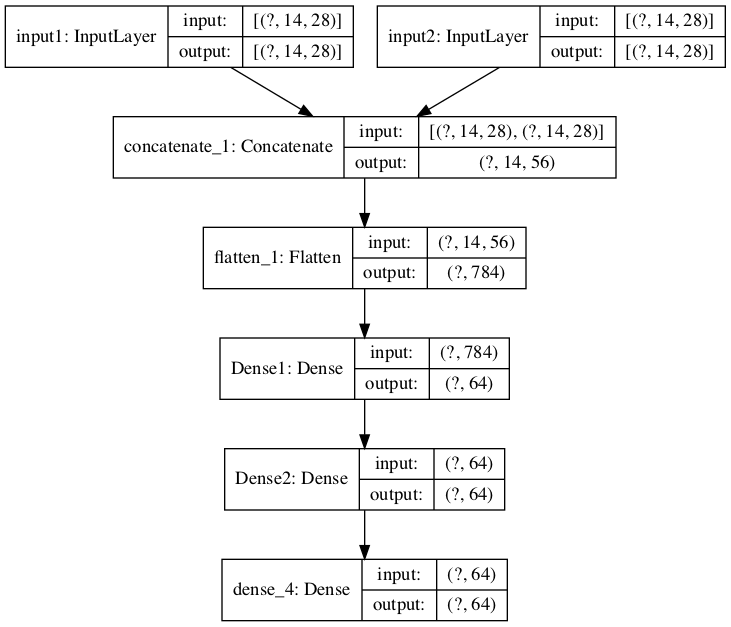

In [19]:
curLayer = layers.Dense(64, activation='relu',name = 'Dense4')(model.get_layer('Dense2').output)
model3 = Model(inputs=[inputImage1,inputImage2], outputs = curLayer)
model3.summary()
utils.plot_model(model3,'mymodel3.png',show_shapes=True)

In [25]:
dense2output = model2.get_layer('Dense2').output
model4 = Model(model2.input,dense2output)
# note that model2.input is actually a list of input tensors
# note that model functions pretty much like a layer: 
# it has a specified input and output tensors 
# and in the predict method it returns an output tensor for an input tensor 
# (only difference is perhaps that we don't specify the input and output tensors the same way)

[<tf.Tensor 'input1_2:0' shape=(None, 14, 28) dtype=float32>, <tf.Tensor 'input2_2:0' shape=(None, 14, 28) dtype=float32>]


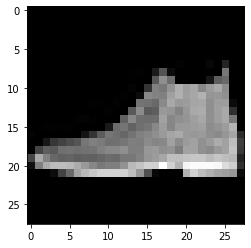

In [31]:
plt.imshow(test_image[0],cmap='gray')
plt.show()

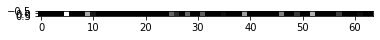

In [37]:
outputImg = model4.predict([test_imageSet1[0:1,:,:],test_imageSet2[0:1,:,:]])
plt.imshow(outputImg,cmap='gray')

In [43]:
# Just like how a model can have multiple inputs and outputs, 
# a layer can also have multiple inputs and outputs
denselayer = layers.Dense(128, activation='relu', name='CustomDense')
# When we don't use a layer as a function by giving it input tensor, it doesn't output a tensor.
# We are just using the constructor here, so it returns the layer object.
input1 = Input((784,))
input2 = Input((784,))
out1 = denselayer(input1)
out2 = denselayer(input2)

In [45]:
# Now we fed two input tensors into denselayer, does it break down or override?
# Neither! It stores two nodes where each node stores the 
# dependency between its own input and output tensors.
# The weights are shared: 
# so if the two inputs have different shapes that require different kernel or bias shape, 
# then they cannot be plugged into the same layer.
# That means, if the kernel and bias shape doens't depend on input shape, 
# any different input shape can be plugged through the same layer. (eg: conv layer)
print(denselayer.weights)
getinput1 = denselayer.get_input_at(node_index=0)
getinput2 = denselayer.get_input_at(node_index=1)
assert input1.name==getinput1.name
assert input2.name==getinput2.name

[<tf.Variable 'CustomDense/kernel:0' shape=(784, 128) dtype=float32, numpy=
array([[ 0.03537042, -0.01892328, -0.00223444, ..., -0.07555058,
        -0.07956502,  0.07119111],
       [-0.00241775,  0.0579691 ,  0.03866287, ..., -0.07051224,
         0.00141266,  0.04654252],
       [-0.01465822,  0.00833196, -0.00311335, ..., -0.00106767,
         0.0361065 ,  0.03611638],
       ...,
       [ 0.04803138,  0.0083086 , -0.01043634, ..., -0.06624188,
         0.07333905, -0.07504245],
       [ 0.06097468,  0.06314274,  0.06859944, ...,  0.04027919,
        -0.06681187,  0.00239766],
       [ 0.01047412,  0.0810727 ,  0.0592457 , ...,  0.06027313,
        -0.03845411, -0.00580619]], dtype=float32)>, <tf.Variable 'CustomDense/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
